## 1. Install prerequisites

In [ ]:
!pip install haystack-ai google-vertex-haystack

In [ ]:
!pip install "sentence-transformers>=2.2.0"
!pip install accelerate

In [ ]:
!pip install elasticsearch-haystack

In [ ]:
!pip install pg8000

In [ ]:
!pip install gradio

## 2. Load data into dataframe
We are using data graciously provided by DoE. It is all publicly available at https://www.osti.gov/

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("gs://gm-doe-qa/input/osti-02-23-2022.csv", index_col=False,
               usecols=['title', 'description', 'publication_date'],
               encoding="utf8",
               nrows=100, # There are about 3M documents. 
              )
df.head()

,title,description,publication_date
0,Abstract for Accelerator Magnets Magnetic Fiel...,The chapter develops the formalism for the two...,2023-12-30T00:00:00Z
1,Analysis of Compressibility Effects and Nonlin...,Calculations are performed using the large edd...,2022-12-29T00:00:00Z
2,Synergistic effects of chlorine substitution i...,All-solid-state battery is considered as one o...,2022-12-09T00:00:00Z
3,Ion Atmosphere of Wormlike Micelles Profiled b...,Structural studies of wormlike micelles have s...,2022-12-01T00:00:00Z
4,State Indicators for Advancing Demand Flexibil...,This slide deck report identifies objectives a...,2022-12-21T00:00:00Z


In [3]:
df.publication_date=pd.to_datetime(df.publication_date).dt.year
df.head()

,title,description,publication_date
0,Abstract for Accelerator Magnets Magnetic Fiel...,The chapter develops the formalism for the two...,2023
1,Analysis of Compressibility Effects and Nonlin...,Calculations are performed using the large edd...,2022
2,Synergistic effects of chlorine substitution i...,All-solid-state battery is considered as one o...,2022
3,Ion Atmosphere of Wormlike Micelles Profiled b...,Structural studies of wormlike micelles have s...,2022
4,State Indicators for Advancing Demand Flexibil...,This slide deck report identifies objectives a...,2022


## 3.Preprocess documents

In [4]:
from haystack import Document

In [5]:
docs=[]
for _, doc in df.iterrows():
    docs.append(
        Document(content=str(doc.description), meta={"title": str(doc.title), "year": str(doc.publication_date)})
    )
docs[:5]

[Document(id=10fdd18c7c6ba6cab20515919c91a81cb8f12f8339738d4d67864f9f1376dedc, content: 'The chapter develops the formalism for the two-dimensional representation of the fields which are co...', meta: {'title': 'Abstract for Accelerator Magnets Magnetic Field Measurements', 'year': '2023'}),
 Document(id=f05c9c0b7f39ab61a609af16b87a84cb61307c00ecfe7fe34ab1d7fa8f486e03, content: 'Calculations are performed using the large eddy simulation technique to qualitatively assess the eff...', meta: {'title': 'Analysis of Compressibility Effects and Nonlinear Property Variations in a Supercritical CO2 Mixing Layer', 'year': '2022'}),
 Document(id=20d3002ffd106f48b246254546d1c203363e842800e9a5a7cf19133d1e3a72f3, content: 'All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. ...', meta: {'title': 'Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries', 'year': '2022'}),
 Document(id=abcff6af401af621e6b04b241eceda456a

### 3.1 Configure ingestion pipeline

In [6]:
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack import Pipeline
from haystack.utils import ComponentDevice

In [7]:
document_cleaner=DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=512, split_overlap=32)
document_embedder = SentenceTransformersDocumentEmbedder(
    model="BAAI/bge-large-en-v1.5", #look for alternatives on https://huggingface.co/spaces/mteb/leaderboard
    device=ComponentDevice.from_str("cuda:0") # note that the embedder is pinned to GPU 0
)

### 3.2 Set up document store
For this example, we will use a locally hosted ElasticSearch container.  
The purpose is to show how to build on existing investment and how to build a hybrid retriever, capable of working on keywords and vector embeddings.

In [8]:
# run this in a terminal
#docker pull docker.elastic.co/elasticsearch/elasticsearch:8.11.1
#docker run -p 9200:9200 -e "discovery.type=single-node" -e "ES_JAVA_OPTS=-Xms1024m -Xmx1024m" -e "xpack.security.enabled=false" elasticsearch:8.11.1

In [9]:
from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore

In [10]:
document_store = ElasticsearchDocumentStore(hosts = "http://localhost:9200")

In [11]:
## pipeline component to write into the store
from haystack.document_stores.types import DuplicatePolicy
document_writer = DocumentWriter(document_store, policy=DuplicatePolicy.OVERWRITE)

### 3.3 Create pipeline

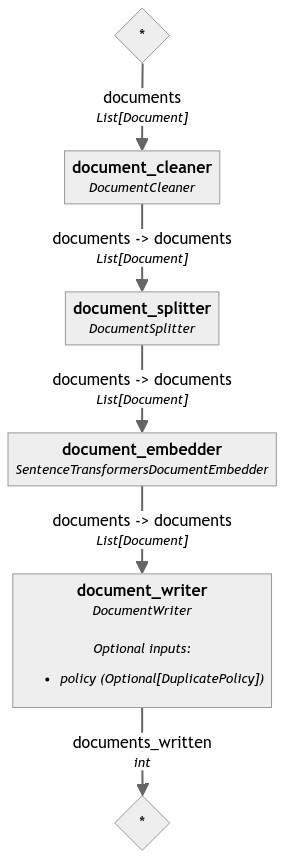

In [12]:
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_cleaner", document_cleaner)
indexing_pipeline.add_component("document_splitter", document_splitter)
indexing_pipeline.add_component("document_embedder", document_embedder)
indexing_pipeline.add_component("document_writer", document_writer)

indexing_pipeline.connect("document_cleaner", "document_splitter")
indexing_pipeline.connect("document_splitter", "document_embedder")
indexing_pipeline.connect("document_embedder", "document_writer")

### 3.4 Run the pipeline
Depending on data quantity, this can take a long time.

In [13]:
indexing_pipeline.run({"document_cleaner": {"documents": docs}})

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 100}}

## 4. Create hybrid retriever
We'll build a pipeline that uses both a bm25 retriever and a vector one

In [14]:
from haystack_integrations.components.retrievers.elasticsearch import ElasticsearchBM25Retriever, ElasticsearchEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(
    model="BAAI/bge-large-en-v1.5",
    device=ComponentDevice.from_str("cuda:0")
)
embedding_retriever = ElasticsearchEmbeddingRetriever(document_store=document_store)
bm25_retriever = ElasticsearchBM25Retriever(document_store=document_store)


### 4.1 Join retrieval results

In [15]:
from haystack.components.joiners import DocumentJoiner

document_joiner = DocumentJoiner(join_mode="concatenate")

### 4.2 Re-rank results 
using a cross-encoder

In [16]:
from haystack.components.rankers import TransformersSimilarityRanker

ranker = TransformersSimilarityRanker(model="BAAI/bge-reranker-base")

### 4.3 Create retrieval pipeline

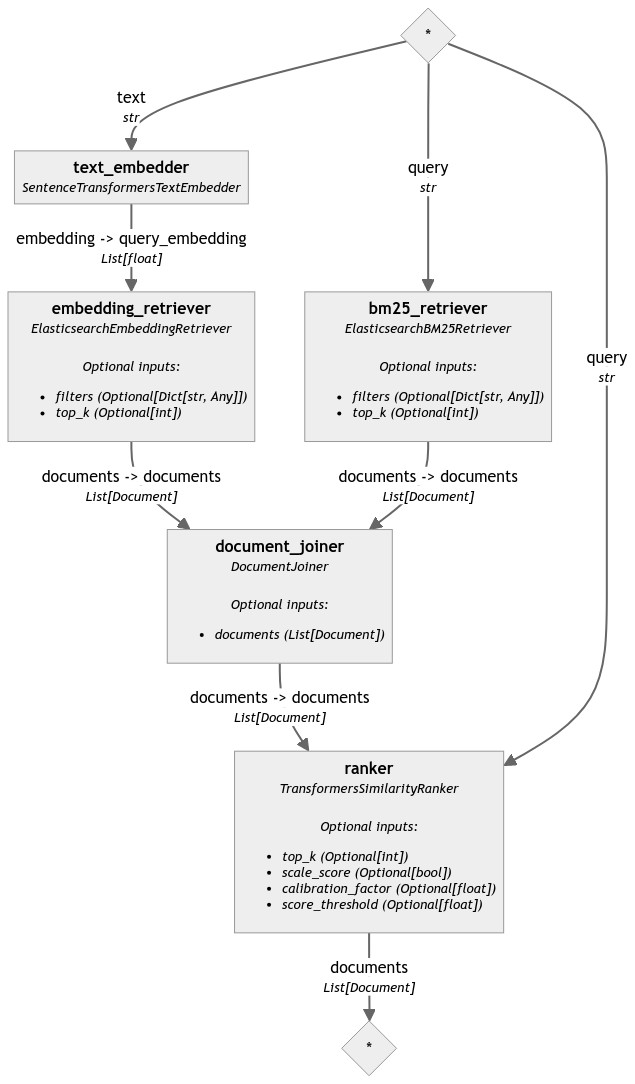

In [17]:
hybrid_retrieval = Pipeline()
hybrid_retrieval.add_component("text_embedder", text_embedder)
hybrid_retrieval.add_component("embedding_retriever", embedding_retriever)
hybrid_retrieval.add_component("bm25_retriever", bm25_retriever)
hybrid_retrieval.add_component("document_joiner", document_joiner)
hybrid_retrieval.add_component("ranker", ranker)

hybrid_retrieval.connect("text_embedder", "embedding_retriever")
hybrid_retrieval.connect("bm25_retriever", "document_joiner")
hybrid_retrieval.connect("embedding_retriever", "document_joiner")
hybrid_retrieval.connect("document_joiner", "ranker")


## 5. Retrieve documents

In [18]:
query = "solid state batteries"

retrieved_docs = hybrid_retrieval.run(
    {"text_embedder": {"text": query}, "bm25_retriever": {"query": query}, "ranker": {"query": query}},
    debug=True
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
retrieved_docs

{'ranker': {'documents': [Document(id=04a9e7b807c59af3fcb4a3a0e22dccbf699f06022ed816679f3c785fe9220060, content: 'All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. ...', meta: {'title': 'Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries', 'year': '2022', 'source_id': '20d3002ffd106f48b246254546d1c203363e842800e9a5a7cf19133d1e3a72f3'}, score: 0.9948267340660095, embedding: vector of size 1024),
   Document(id=d9caff4f06bc4f39a4c89788dbfaffa8a258175a35e0987721245bc9baf9ea70, content: 'Here we demonstrate a theory-driven, novel dual-shell coating system of Li2SrSiO4 and Al2O3, achieve...', meta: {'title': 'Dual-shell silicate and alumina coating for long lasting and high capacity lithium ion batteries', 'year': '2022', 'source_id': 'f0b5cc70966d18422d6ccec522d35c743e6309582488eea1f71f365c2da9b3d5'}, score: 0.0028873381670564413, embedding: vector of size 1024),
   Document(id=f59189768f4d5b7ffebe54cb

In [20]:
retrieved_docs.items()

dict_items([('ranker', {'documents': [Document(id=04a9e7b807c59af3fcb4a3a0e22dccbf699f06022ed816679f3c785fe9220060, content: 'All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. ...', meta: {'title': 'Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries', 'year': '2022', 'source_id': '20d3002ffd106f48b246254546d1c203363e842800e9a5a7cf19133d1e3a72f3'}, score: 0.9948267340660095, embedding: vector of size 1024), Document(id=d9caff4f06bc4f39a4c89788dbfaffa8a258175a35e0987721245bc9baf9ea70, content: 'Here we demonstrate a theory-driven, novel dual-shell coating system of Li2SrSiO4 and Al2O3, achieve...', meta: {'title': 'Dual-shell silicate and alumina coating for long lasting and high capacity lithium ion batteries', 'year': '2022', 'source_id': 'f0b5cc70966d18422d6ccec522d35c743e6309582488eea1f71f365c2da9b3d5'}, score: 0.0028873381670564413, embedding: vector of size 1024), Document(id=f59189768f4d5b7ffe

In [21]:
def pretty_print_results(prediction):
    for doc in prediction["documents"]:
        print(doc.meta["title"], "\t", doc.meta["year"], "\t", doc.score)
        print(doc.content)
        print("\n", "\n")


In [22]:
pretty_print_results(retrieved_docs["ranker"])


Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries 	 2022 	 0.9948267340660095
All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. Two widely known performance metrics for solid electrolytes, among others, are ionic conductivity and stability. In this study, it is found that both can be improved by the synergistic effects of chlorine substitution in sulfide-based solid electrolytes. Particularly, instabilities arising from both bulk decompositions and interfacial reactions to electrodes can be better inhibited in the chlorine substituted sulfide solid electrolytes through the increased susceptibility to the mechanical constriction induced enhancement of voltage stability. As a result, the stability window of some chlorine-rich Li-argyrodites can be systematically higher than some other chlorine-deficient or chlorine-free electrolytes, especially under the implementation of the mechanical constriction

## 6. Generate answer

### 6.1 with Gemini

In [23]:
from haystack_integrations.components.generators.google_vertex import VertexAIGeminiGenerator
from haystack.components.builders.prompt_builder import PromptBuilder

In [24]:
PROJECT_ID="<INSERT_PROJECT_ID_HERE>"

In [25]:
gemini = VertexAIGeminiGenerator(model="gemini-pro", project_id=PROJECT_ID,
                                generation_config={
                                    "temperature": 0.2,
                                    "top_p": 0.5,
                                    "top_k": 40,
                                    "max_output_tokens": 4096 ,
                                    #"stop_sequences": config._raw_generation_config.stop_sequences,
                                })

prompt_template = """
According to these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the question: {{question}}
"""
prompt_builder = PromptBuilder(template=prompt_template)

In [26]:
gen_pipe=Pipeline()

In [27]:
gen_pipe.add_component("prompt_builder", prompt_builder)
gen_pipe.add_component("gemini", gemini)

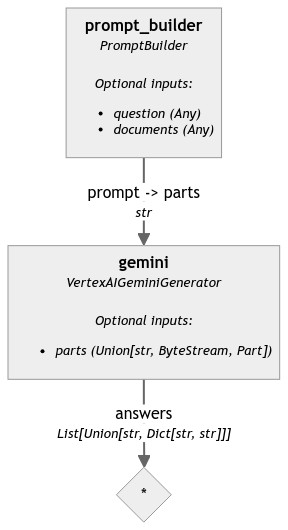

In [28]:
gen_pipe.connect("prompt_builder.prompt", "gemini")

In [29]:
result=gen_pipe.run(
    {"prompt_builder": {"question": query, "documents": retrieved_docs["ranker"]["documents"]}
    }
)

In [30]:
result

{'gemini': {'answers': ['All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. Two widely known performance metrics for solid electrolytes, among others, are ionic conductivity and stability. In this study, it is found that both can be improved by the synergistic effects of chlorine substitution in sulfide-based solid electrolytes. Particularly, instabilities arising from both bulk decompositions and interfacial reactions to electrodes can be better inhibited in the chlorine substituted sulfide solid electrolytes through the increased susceptibility to the mechanical constriction induced enhancement of voltage stability. As a result, the stability window of some chlorine-rich Li-argyrodites can be systematically higher than some other chlorine-deficient or chlorine-free electrolytes, especially under the implementation of the mechanical constriction battery assembly and test conditions. Thus, a solid-state battery system of 4 V to 5 V-class

In [31]:
def qa(question: str):
    retrieved_docs = hybrid_retrieval.run(
        {"text_embedder": {"text": question}, "bm25_retriever": {"query": question}, "ranker": {"query": question}}
    )
    answers = gen_pipe.run(
        {"prompt_builder": {"question": question, "documents": retrieved_docs["ranker"]["documents"]}}
    )
    return retrieved_docs, answers
    
         

In [32]:
retrieved_docs, answers= qa("solid state batteries")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
answers

{'gemini': {'answers': ['All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. Two widely known performance metrics for solid electrolytes, among others, are ionic conductivity and stability. In this study, it is found that both can be improved by the synergistic effects of chlorine substitution in sulfide-based solid electrolytes. Particularly, instabilities arising from both bulk decompositions and interfacial reactions to electrodes can be better inhibited in the chlorine substituted sulfide solid electrolytes through the increased susceptibility to the mechanical constriction induced enhancement of voltage stability. As a result, the stability window of some chlorine-rich Li-argyrodites can be systematically higher than some other chlorine-deficient or chlorine-free electrolytes, especially under the implementation of the mechanical constriction battery assembly and test conditions. Thus, a solid-state battery system of 4 V to 5 V-class

In [34]:
from tabulate import tabulate
def tabulate_results(prediction):
    table=[]
    for doc in prediction["documents"]:
        table.append([doc.meta["title"], doc.meta["year"], doc.score, doc.content])
    return pd.DataFrame(table, columns=["title", "year", "score", "content"])

In [35]:
table=tabulate_results(retrieved_docs["ranker"])

In [36]:
print(tabulate(table.iloc[:,:-1], headers=table.columns[:-1]))

    title                                                                                                                                 year        score
--  ----------------------------------------------------------------------------------------------------------------------------------  ------  -----------
 0  Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries                                             2022  0.994827
 1  Dual-shell silicate and alumina coating for long lasting and high capacity lithium ion batteries                                      2022  0.00288734
 2  Effects of temperature and time on supercritical methanol Co-Liquefaction of rice straw and linear low-density polyethylene wastes    2022  0.00261771
 3  Approaching theoretical specific capacity of iron-rich lithium iron silicate using graphene-incorporation and fluorine-doping         2022  0.00209044
 4  State Indicators for Advancing Demand Flexibility and Energy Effic

In [37]:
print(answers["gemini"]["answers"])

['All-solid-state battery is considered as one of the most promising competitors to Li ion batteries. Two widely known performance metrics for solid electrolytes, among others, are ionic conductivity and stability. In this study, it is found that both can be improved by the synergistic effects of chlorine substitution in sulfide-based solid electrolytes. Particularly, instabilities arising from both bulk decompositions and interfacial reactions to electrodes can be better inhibited in the chlorine substituted sulfide solid electrolytes through the increased susceptibility to the mechanical constriction induced enhancement of voltage stability. As a result, the stability window of some chlorine-rich Li-argyrodites can be systematically higher than some other chlorine-deficient or chlorine-free electrolytes, especially under the implementation of the mechanical constriction battery assembly and test conditions. Thus, a solid-state battery system of 4 V to 5 V-class cathodes paired with l

### 6.2 with Gemma
We are downloading Gemma from HuggingFace. You will need a token (freely provided) from huggingface.com

In [25]:
import getpass, os
HUGGING_FACE_TOKEN=getpass.getpass("Your hugging face access token: ")
os.environ["HF_API_TOKEN"] = HUGGING_FACE_TOKEN 

In [26]:
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(
    model="google/gemma-2b-it",
    generation_kwargs={"max_new_tokens": 500, "temperature": 0.2},
    device=ComponentDevice.from_str("cuda:1")
)

generator.warm_up()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
gemma_prompt_template= """
Using ONLY these documents:

{% for doc in documents %}
  {{ doc.content }}
{% endfor %}

Answer the question: {{question}}
"""

In [28]:
gemma_prompt_builder = PromptBuilder(template=gemma_prompt_template)

In [35]:
gemma_pipe=Pipeline()

gemma_pipe.add_component("gemma_prompt_builder", gemma_prompt_builder)

gemma_pipe.add_component("gemma", generator)

gemma_pipe.connect("gemma_prompt_builder.prompt", "gemma")

In [29]:
question="summarize finding about solid state batteries"


In [65]:
def gemma_qa(question, topk, temp):
    retrieved_docs = hybrid_retrieval.run(
        {"text_embedder": {"text": question}, "bm25_retriever": {"query": question}, "ranker": {"query": question}}
    )
    answers = gemma_pipe.run(
        {"gemma_prompt_builder": {"question": question, "documents": retrieved_docs["ranker"]["documents"]}}
    )
    table=tabulate_results(retrieved_docs["ranker"])
    answer0=gemma_answers["gemma"]["replies"][0]
    return answer0, table.iloc[:,:-1] #retrieved_docs, answers

In [69]:
gemma_answer, gemma_table= gemma_qa(question, 1, 2)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [70]:
print(tabulate(gemma_table, gemma_table.columns))

    title                                                                                                                            year       score
--  -----------------------------------------------------------------------------------------------------------------------------  ------  ----------
 0  Synergistic effects of chlorine substitution in sulfide electrolyte solid state batteries                                        2022  0.400996
 1  Dual-shell silicate and alumina coating for long lasting and high capacity lithium ion batteries                                 2022  0.0200244
 2  Unraveling transition-metal-mediated stability of spinel oxide via in situ neutron scattering                                    2022  0.0179024
 3  Excited states of lutetium oxide and its singly charged cation                                                                   2022  0.0073172
 4  Density of states prediction for materials discovery via contrastive learning from probabilistic embe

In [71]:
print(gemma_answer)



A solid state battery is a type of battery that uses a solid electrolyte instead of a liquid electrolyte. This solid electrolyte allows the battery to operate at higher temperatures and to store more energy than a liquid electrolyte battery. Solid state batteries are also more environmentally friendly than liquid electrolyte batteries, as they do not require the use of hazardous chemicals.


## 7. Build an interface
Simple interface with Gradio https://www.gradio.app/. Also consider Streamlit.

In [72]:
import gradio as gr

In [79]:
# Gradio interface definition
interface = gr.Interface(
    fn=gemma_qa,
    inputs=[gr.Textbox(label="Search"), gr.Slider(minimum=1, maximum=10, label="Top_K"), gr.Slider(minimum=0.0, maximum=1.0, label="Temperature")],
    outputs=[gr.Text(), gr.Dataframe(headers=["Title", "Year", "Score"], wrap=True)],
    title="Elsa 1.5",
    description="",
)

In [80]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://eb6134694688d506bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [81]:
interface.close()

Closing server running on port: 7860
